In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display, clear_output
from warnings import filterwarnings

In [2]:
from zipfile import ZipFile
with ZipFile("activityfile.zip",'r') as zipObj:
  zipObj.extractall('act')


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
for dirname, _, filenames in os.walk('act/activity_rec'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

act/activity_rec/washing_dishes/washing_dishes_159.jpg
act/activity_rec/washing_dishes/washing_dishes_071.jpg
act/activity_rec/washing_dishes/washing_dishes_152.jpg
act/activity_rec/washing_dishes/washing_dishes_092.jpg
act/activity_rec/washing_dishes/washing_dishes_052.jpg
act/activity_rec/washing_dishes/washing_dishes_180.jpg
act/activity_rec/washing_dishes/washing_dishes_131.jpg
act/activity_rec/washing_dishes/washing_dishes_181.jpg
act/activity_rec/washing_dishes/washing_dishes_153.jpg
act/activity_rec/washing_dishes/washing_dishes_041.jpg
act/activity_rec/washing_dishes/washing_dishes_157.jpg
act/activity_rec/washing_dishes/washing_dishes_059.jpg
act/activity_rec/washing_dishes/washing_dishes_040.jpg
act/activity_rec/washing_dishes/washing_dishes_109.jpg
act/activity_rec/washing_dishes/washing_dishes_095.jpg
act/activity_rec/washing_dishes/washing_dishes_097.jpg
act/activity_rec/washing_dishes/washing_dishes_057.jpg
act/activity_rec/washing_dishes/washing_dishes_027.jpg
act/activi

In [5]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_blue = ['#003396', '#1750AC', '#3373C4', '#73B9EE','#86CEFA']
colors_pink = ['#342415','#442e19','#54381d','#654321','#7f5f42']

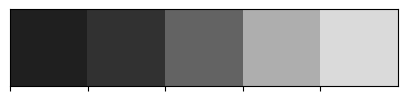

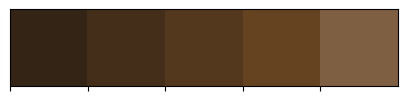

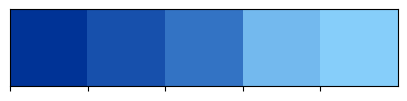

In [6]:
sns.palplot(colors_dark)
sns.palplot(colors_pink)
sns.palplot(colors_blue)

In [7]:
labels = ['applauding','blowing_bubbles','brushing_teeth','cleaning _the_floor','climbing','cooking','cutting_trees','cutting_vegetables','drinking','feeding_horse','fishing','fixing_a_bike','fixing_a_car','gardening','holding_an_umbrella','jumping','looking_through_a_microscope','looking_through_a_telescope','phoning','playing_guitar','playing_violin','pouring_liquid','pushing_a_cart','reading','riding_a_bike','riding_a_horse','rowing_a_boat','running','shooting_an_arrow','smoking','taking_photos','texting_message','throwing_frisby','using_a_computer','walking_the_dog','washing_dishes','watching_TV','waving_hands','writing_on_a_board','writing_on_a_book']
X_train = []
y_train = []
image_size = 150
for i in labels:
    folderPath = os.path.join('act', 'activity_rec', i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)


100%|██████████| 246/246 [00:00<00:00, 552.37it/s]


In [8]:
X_train = np.array(X_train)
y_train = np.array(y_train)


(9607, 150, 150, 3)

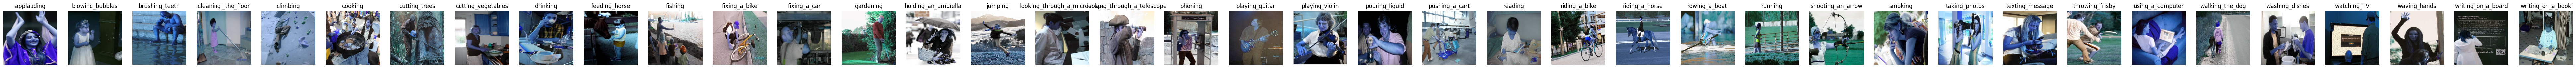

In [9]:

k=0
fig, ax = plt.subplots(1,40,figsize=(100,12))
# fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
#              fontname='monospace',color=colors_dark[1],y=0.6,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1
X_train, y_train = shuffle(X_train,y_train, random_state=101)
X_train.shape

In [10]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.2,random_state=101)
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

In [11]:
y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [12]:
xception = Xception(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [13]:
model = tf.keras.models.Sequential()
model.add(xception)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dropout(rate=0.5))
model.add(tf.keras.layers.Dense(40, activation='softmax'))

In [14]:

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 5, 5, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 40)             │        81,960 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,943,440 (79.89 MB)

 Trainable params: 20,888,912 (79.68 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [15]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])


In [16]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("/content/drive/MyDrive/Human.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [17]:

history = model.fit(X_train,y_train,validation_split=0.2, epochs =15, verbose=1, batch_size=64,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 617ms/step - accuracy: 0.2814 - loss: 2.7555
Epoch 1: val_accuracy improved from -inf to 0.27261, saving model to /content/drive/MyDrive/Human.h5


97/97 ━━━━━━━━━━━━━━━━━━━━ 153s 927ms/step - accuracy: 0.2827 - loss: 2.7499 - val_accuracy: 0.2726 - val_loss: 4.6908 - learning_rate: 0.0010
Epoch 2/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.6825 - loss: 1.0977
Epoch 2: val_accuracy improved from 0.27261 to 0.42746, saving model to /content/drive/MyDrive/Human.h5


97/97 ━━━━━━━━━━━━━━━━━━━━ 64s 517ms/step - accuracy: 0.6825 - loss: 1.0974 - val_accuracy: 0.4275 - val_loss: 2.4197 - learning_rate: 0.0010
Epoch 3/15
96/97 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - accuracy: 0.7982 - loss: 0.6636
Epoch 3: val_accuracy improved from 0.42746 to 0.49902, saving model to /content/drive/MyDrive/Human.h5


97/97 ━━━━━━━━━━━━━━━━━━━━ 53s 550ms/step - accuracy: 0.7984 - loss: 0.6630 - val_accuracy: 0.4990 - val_loss: 2.0190 - learning_rate: 0.0010
Epoch 4/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.8963 - loss: 0.3636
Epoch 4: val_accuracy did not improve from 0.49902
97/97 ━━━━━━━━━━━━━━━━━━━━ 44s 451ms/step - accuracy: 0.8962 - loss: 0.3637 - val_accuracy: 0.4789 - val_loss: 2.1700 - learning_rate: 0.0010
Epoch 5/15
96/97 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - accuracy: 0.8704 - loss: 0.4435
Epoch 5: val_accuracy did not improve from 0.49902

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
97/97 ━━━━━━━━━━━━━━━━━━━━ 82s 449ms/step - accuracy: 0.8706 - loss: 0.4427 - val_accuracy: 0.4782 - val_loss: 2.4433 - learning_rate: 0.0010
Epoch 6/15
96/97 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - accuracy: 0.9595 - loss: 0.1492
Epoch 6: val_accuracy improved from 0.49902 to 0.66168, saving model to /content/drive/MyDrive/Human.h5


97/97 ━━━━━━━━━━━━━━━━━━━━ 49s 506ms/step - accuracy: 0.9597 - loss: 0.1486 - val_accuracy: 0.6617 - val_loss: 1.4546 - learning_rate: 3.0000e-04
Epoch 7/15
96/97 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.9944 - loss: 0.0285
Epoch 7: val_accuracy improved from 0.66168 to 0.69356, saving model to /content/drive/MyDrive/Human.h5


97/97 ━━━━━━━━━━━━━━━━━━━━ 48s 491ms/step - accuracy: 0.9945 - loss: 0.0285 - val_accuracy: 0.6936 - val_loss: 1.2901 - learning_rate: 3.0000e-04
Epoch 8/15
96/97 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.9977 - loss: 0.0175
Epoch 8: val_accuracy did not improve from 0.69356
97/97 ━━━━━━━━━━━━━━━━━━━━ 80s 473ms/step - accuracy: 0.9977 - loss: 0.0175 - val_accuracy: 0.6818 - val_loss: 1.3169 - learning_rate: 3.0000e-04
Epoch 9/15
97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.9998 - loss: 0.0070
Epoch 9: val_accuracy did not improve from 0.69356

Epoch 9: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
97/97 ━━━━━━━━━━━━━━━━━━━━ 80s 448ms/step - accuracy: 0.9998 - loss: 0.0070 - val_accuracy: 0.6871 - val_loss: 1.3589 - learning_rate: 3.0000e-04
Epoch 10/15
96/97 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.9995 - loss: 0.0046
Epoch 10: val_accuracy did not improve from 0.69356
97/97 ━━━━━━━━━━━━━━━━━━━━ 84s 473ms/step - accuracy: 0.9995 - loss: 0.0

In [18]:
import tensorflow as tf
import keras
from keras.models import load_model

activity_model = load_model('/content/drive/MyDrive/Human.h5', compile=False)

In [19]:
converter = tf.lite.TFLiteConverter.from_keras_model(activity_model)
#converter.optimizations = [tf.lite.Optimize.DEFAULT] #Uses default optimization strategy to reduce the model size
tflite_model = converter.convert()
open("/content/drive/MyDrive/Human.tflite", "wb").write(tflite_model)

Saved artifact at '/tmp/tmpesfqza7e'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 40), dtype=tf.float32, name=None)
Captures:
  135143418265424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135143418263888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135143418264272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135143418263696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135143418263120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135143418265040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135143418262928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135143418265232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135143418264464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135143418264080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135143418264

83499844

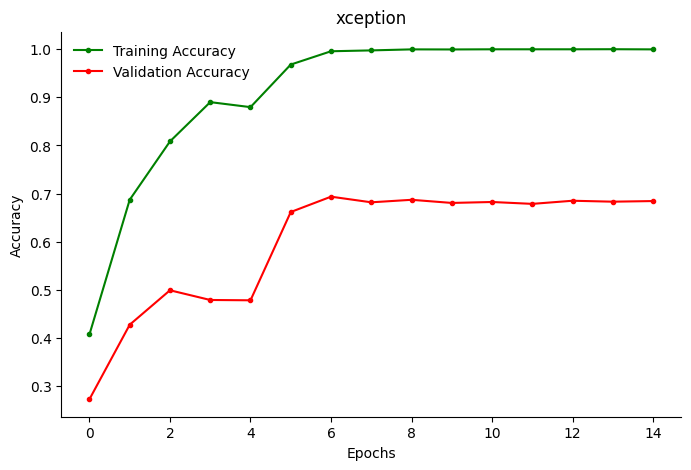

In [20]:

filterwarnings('ignore')
epochs = [i for i in range(15)]
fig, ax = plt.subplots(1,1,figsize=(8,5))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']

val_loss = history.history['val_loss']

# fig.text(s='Efficient-NetV2B2 Accuracy ',size=16,fontweight='bold',
#               fontname='monospace',color=colors_dark[1],y=1,x=0.28,alpha=0.8)
sns.despine()
ax.plot(epochs, train_acc, marker='.',markerfacecolor='green',color='green',
           label = 'Training Accuracy')
ax.plot(epochs, val_acc, marker='.',markerfacecolor='red',color='red',
           label = 'Validation Accuracy')
ax.legend(frameon=False)
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.set_title('xception')
sns.set_theme()
plt.savefig("/content/drive/MyDrive/ALLOUTPUT/xception_for_har.eps",dpi=600)
fig.show()

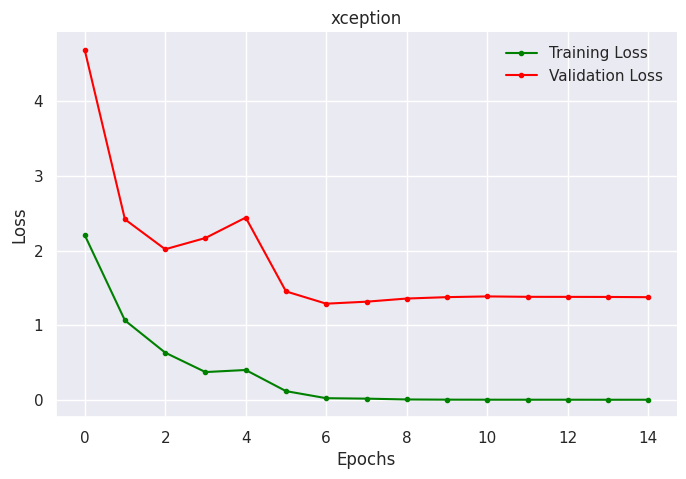

In [21]:
filterwarnings('ignore')
epochs = [i for i in range(15)]
fig, ax = plt.subplots(1,1,figsize=(8,5))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
# fig.text(s='Efficient-NetV2B2',size=8,fontweight='bold',
#               color=colors_dark[1],y=1,x=0.28,alpha=0.8)

sns.despine()
ax.plot(epochs, train_loss, marker='.',markerfacecolor='green',color='green',
           label ='Training Loss')
ax.plot(epochs, val_loss, marker='.',markerfacecolor='red',color='red',
           label = 'Validation Loss')
ax.legend(frameon=False)
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_title('xception')
plt.savefig("/content/drive/MyDrive/ALLOUTPUT/xception_los_for_har.eps",dpi=600)
fig.show()

In [22]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test= np.argmax(y_test,axis=1)

y_test=y_test.reshape(-1,1)

y_test.shape

print(classification_report(y_test,pred))

61/61 ━━━━━━━━━━━━━━━━━━━━ 14s 113ms/step
              precision    recall  f1-score   support

           0       0.50      0.47      0.49        57
           1       0.63      0.61      0.62        62
           2       0.39      0.46      0.43        28
           3       0.82      0.83      0.82        48
           4       0.77      0.98      0.86        55
           5       0.51      0.46      0.48        52
           6       0.78      0.71      0.74        41
           7       0.51      0.53      0.52        38
           8       0.38      0.39      0.39        41
           9       0.84      0.82      0.83        56
          10       0.79      0.79      0.79        72
          11       0.77      0.77      0.77        43
          12       0.82      0.83      0.82        59
          13       0.58      0.82      0.68        38
          14       0.84      0.88      0.86        49
          15       0.79      0.83      0.81        54
          16       0.87      0.87      

In [24]:
labels = np.unique(y_test)
cm = confusion_matrix(y_test, pred, labels=labels)

In [26]:
# Calculate sensitivity and specificity

TP = np.diag(cm)
FP = cm.sum(axis=0) - TP
FN = cm.sum(axis=1) - TP
TN = cm.sum() - (FP + FN + TP)

sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

# Print sensitivity and specificity
for i, label in enumerate(labels):
    print(f"{label}: Sensitivity = {sensitivity[i]}, Specificity = {specificity[i]}")

0: Sensitivity = 0.47368421052631576, Specificity = 0.9855227882037534
1: Sensitivity = 0.6129032258064516, Specificity = 0.9881720430107527
2: Sensitivity = 0.4642857142857143, Specificity = 0.989440337909187
3: Sensitivity = 0.8333333333333334, Specificity = 0.9951974386339381
4: Sensitivity = 0.9818181818181818, Specificity = 0.9914301017675415
5: Sensitivity = 0.46153846153846156, Specificity = 0.9877005347593583
6: Sensitivity = 0.7073170731707317, Specificity = 0.9957469431153642
7: Sensitivity = 0.5263157894736842, Specificity = 0.9899150743099787
8: Sensitivity = 0.3902439024390244, Specificity = 0.9861775651249336
9: Sensitivity = 0.8214285714285714, Specificity = 0.9951768488745981
10: Sensitivity = 0.7916666666666666, Specificity = 0.9918918918918919
11: Sensitivity = 0.7674418604651163, Specificity = 0.9946780202235231
12: Sensitivity = 0.8305084745762712, Specificity = 0.9940955448201825
13: Sensitivity = 0.8157894736842105, Specificity = 0.9883227176220807
14: Sensitivity

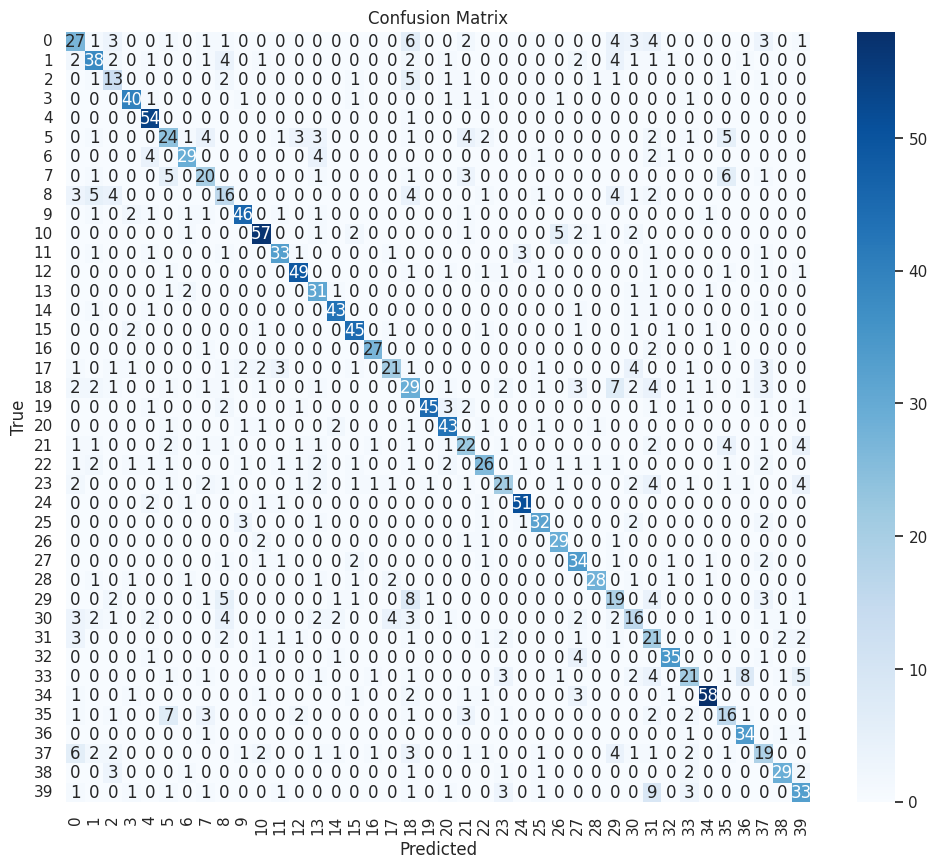

In [27]:
# Generate confusion matrix table
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
plt.figure(figsize=(12, 10))
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [28]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [29]:
# Calculate sensitivity and specificity
TP = np.diag(cm)
FP = cm.sum(axis=0) - TP
FN = cm.sum(axis=1) - TP
TN = cm.sum() - (FP + FN)

sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

In [30]:
# Print sensitivity and specificity
for i, label in enumerate(labels):
    print(f"{label}: Sensitivity = {sensitivity[i]}, Specificity = {specificity[i]}")

# Calculate overall sensitivity and specificity
overall_sensitivity = np.mean(sensitivity)
overall_specificity = np.mean(specificity)

print(f"Overall Sensitivity: {overall_sensitivity}")
print(f"Overall Specificity: {overall_specificity}")

0: Sensitivity = 0.47368421052631576, Specificity = 0.9857293868921776
1: Sensitivity = 0.6129032258064516, Specificity = 0.9884088514225501
2: Sensitivity = 0.4642857142857143, Specificity = 0.989512323020451
3: Sensitivity = 0.8333333333333334, Specificity = 0.9952978056426333
4: Sensitivity = 0.9818181818181818, Specificity = 0.9916710046850599
5: Sensitivity = 0.46153846153846156, Specificity = 0.9878563885955649
6: Sensitivity = 0.7073170731707317, Specificity = 0.9958115183246073
7: Sensitivity = 0.5263157894736842, Specificity = 0.9900210084033614
8: Sensitivity = 0.3902439024390244, Specificity = 0.9862941486557723
9: Sensitivity = 0.8214285714285714, Specificity = 0.9952928870292888
10: Sensitivity = 0.7916666666666666, Specificity = 0.9921342422653382
11: Sensitivity = 0.7674418604651163, Specificity = 0.9947698744769874
12: Sensitivity = 0.8305084745762712, Specificity = 0.9942468619246861
13: Sensitivity = 0.8157894736842105, Specificity = 0.9885117493472585
14: Sensitivity

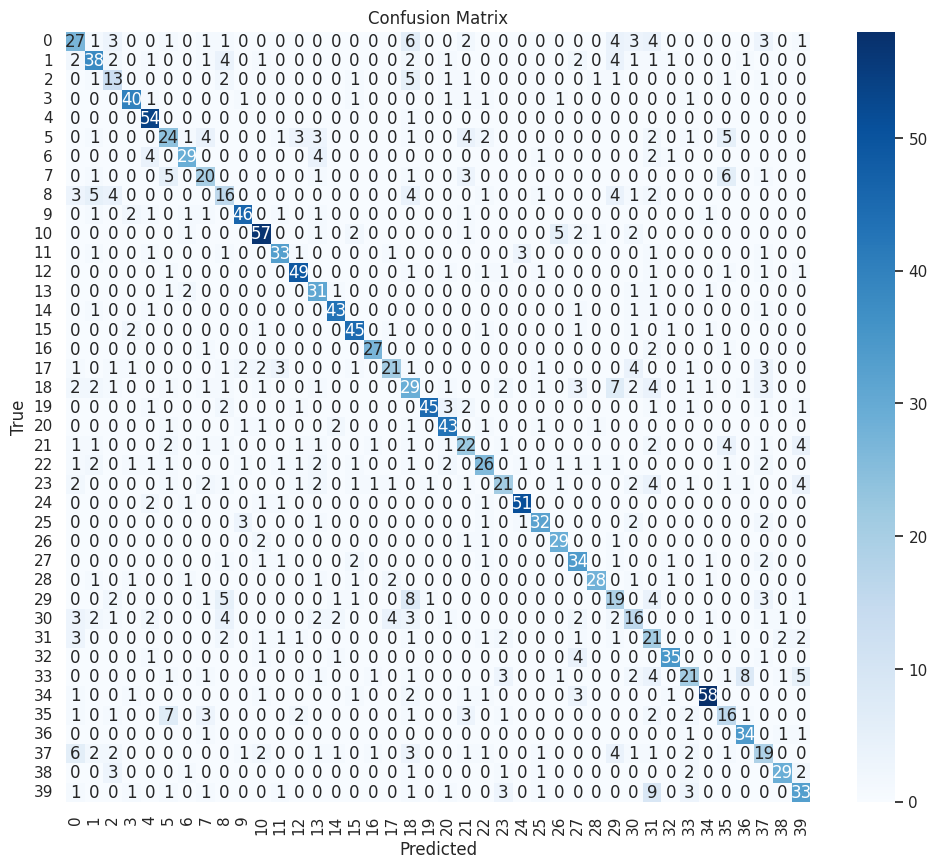

In [31]:
# Generate confusion matrix table
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
plt.figure(figsize=(12, 10))
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [32]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [33]:
# Calculate sensitivity and specificity
TP = np.diag(cm)
FP = cm.sum(axis=0) - TP
FN = cm.sum(axis=1) - TP
TN = cm.sum() - (FP + FN + TP)

sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)


In [34]:
# Print sensitivity and specificity
for i, label in enumerate(labels):
    print(f"{label}: Sensitivity = {sensitivity[i]}, Specificity = {specificity[i]}")

0: Sensitivity = 0.47368421052631576, Specificity = 0.9855227882037534
1: Sensitivity = 0.6129032258064516, Specificity = 0.9881720430107527
2: Sensitivity = 0.4642857142857143, Specificity = 0.989440337909187
3: Sensitivity = 0.8333333333333334, Specificity = 0.9951974386339381
4: Sensitivity = 0.9818181818181818, Specificity = 0.9914301017675415
5: Sensitivity = 0.46153846153846156, Specificity = 0.9877005347593583
6: Sensitivity = 0.7073170731707317, Specificity = 0.9957469431153642
7: Sensitivity = 0.5263157894736842, Specificity = 0.9899150743099787
8: Sensitivity = 0.3902439024390244, Specificity = 0.9861775651249336
9: Sensitivity = 0.8214285714285714, Specificity = 0.9951768488745981
10: Sensitivity = 0.7916666666666666, Specificity = 0.9918918918918919
11: Sensitivity = 0.7674418604651163, Specificity = 0.9946780202235231
12: Sensitivity = 0.8305084745762712, Specificity = 0.9940955448201825
13: Sensitivity = 0.8157894736842105, Specificity = 0.9883227176220807
14: Sensitivity

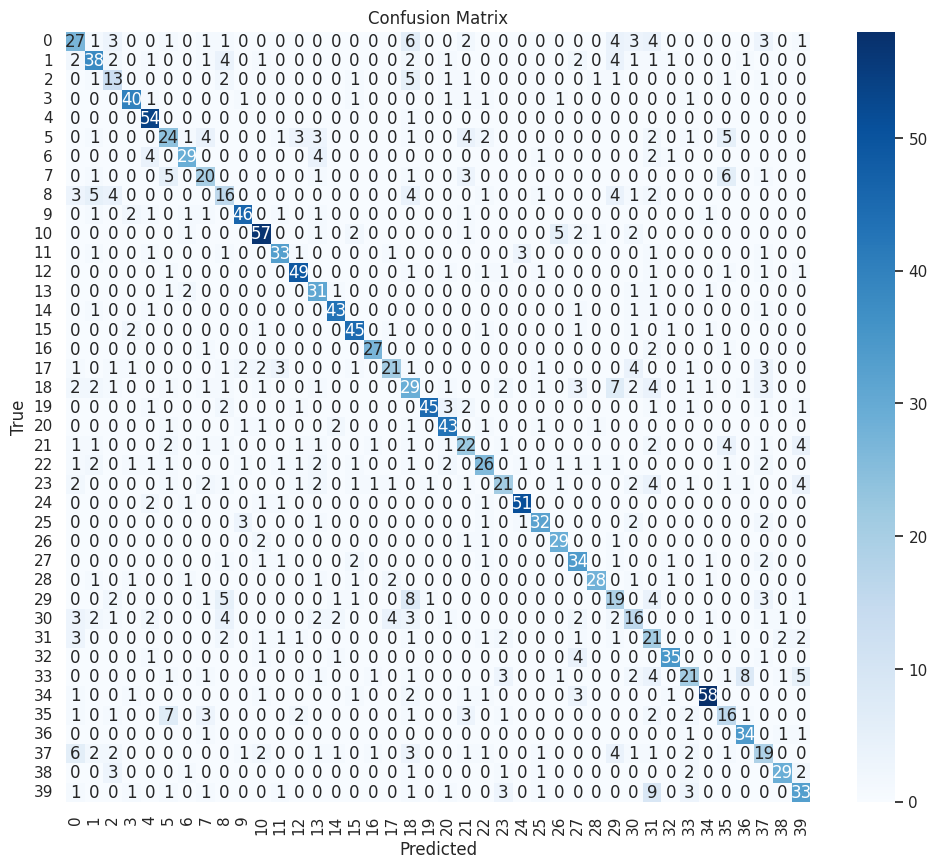

In [35]:

# Generate confusion matrix table
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
plt.figure(figsize=(12, 10))
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()




In [36]:
print(cm)

[[27  1  3 ...  3  0  1]
 [ 2 38  2 ...  0  0  0]
 [ 0  1 13 ...  1  0  0]
 ...
 [ 6  2  2 ... 19  0  0]
 [ 0  0  3 ...  0 29  2]
 [ 1  0  0 ...  0  0 33]]


In [37]:

from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

(<Figure size 800x700 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

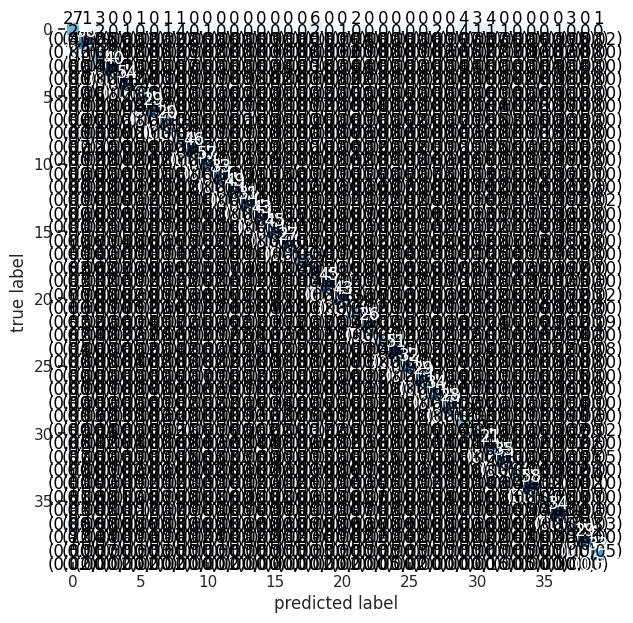

In [38]:
cm = confusion_matrix(y_test,pred)
plot_confusion_matrix(conf_mat = cm,figsize=(8,7),
                     show_normed = True)


In [39]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, pred)

In [40]:
# Calculate sensitivity and specificity
TP = np.diag(cm)
FP = cm.sum(axis=0) - TP
FN = cm.sum(axis=1) - TP
TN = cm.sum() - (FP + FN + TP)

sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

In [41]:
# Print sensitivity and specificity
for i, label in enumerate(labels):
    print(f"{label}: Sensitivity = {sensitivity[i]}, Specificity = {specificity[i]}")

0: Sensitivity = 0.47368421052631576, Specificity = 0.9855227882037534
1: Sensitivity = 0.6129032258064516, Specificity = 0.9881720430107527
2: Sensitivity = 0.4642857142857143, Specificity = 0.989440337909187
3: Sensitivity = 0.8333333333333334, Specificity = 0.9951974386339381
4: Sensitivity = 0.9818181818181818, Specificity = 0.9914301017675415
5: Sensitivity = 0.46153846153846156, Specificity = 0.9877005347593583
6: Sensitivity = 0.7073170731707317, Specificity = 0.9957469431153642
7: Sensitivity = 0.5263157894736842, Specificity = 0.9899150743099787
8: Sensitivity = 0.3902439024390244, Specificity = 0.9861775651249336
9: Sensitivity = 0.8214285714285714, Specificity = 0.9951768488745981
10: Sensitivity = 0.7916666666666666, Specificity = 0.9918918918918919
11: Sensitivity = 0.7674418604651163, Specificity = 0.9946780202235231
12: Sensitivity = 0.8305084745762712, Specificity = 0.9940955448201825
13: Sensitivity = 0.8157894736842105, Specificity = 0.9883227176220807
14: Sensitivity

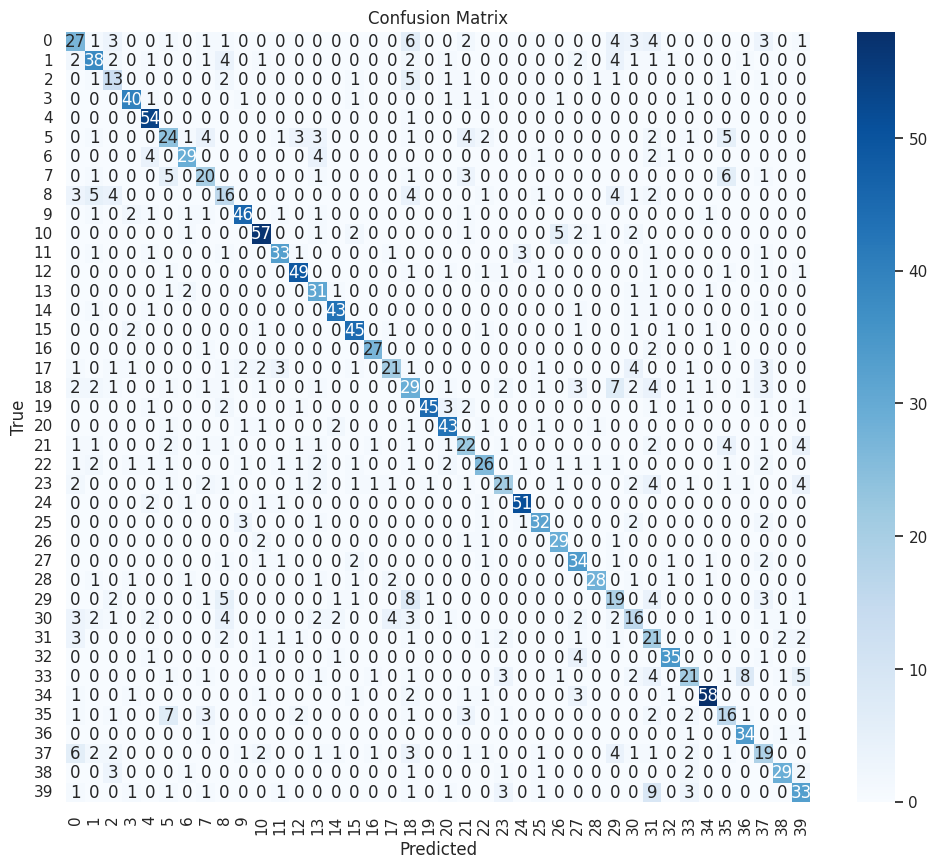

In [42]:
# Generate confusion matrix table
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
plt.figure(figsize=(12, 10))
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

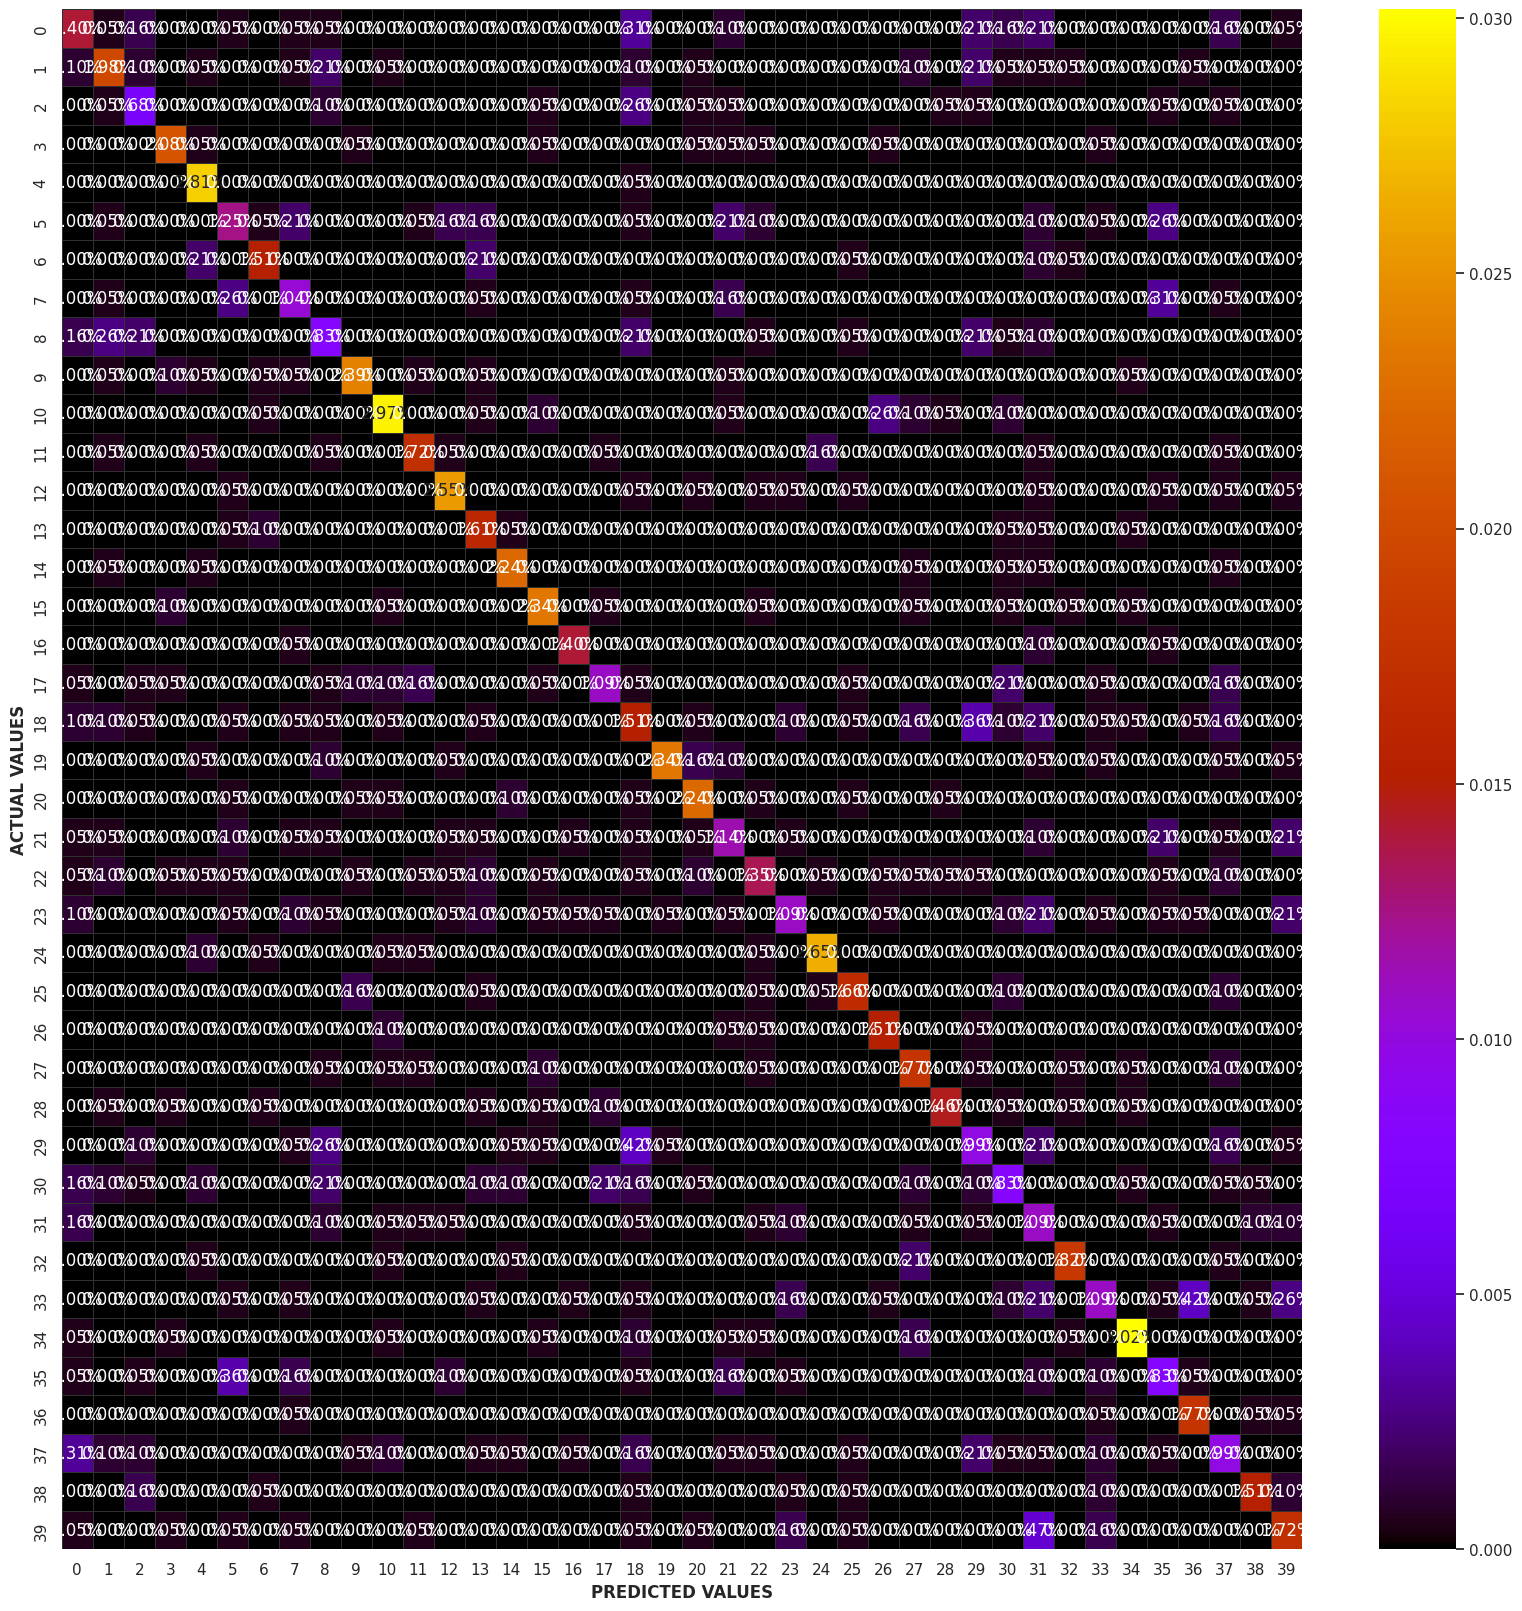

In [43]:
fig,ax=plt.subplots(1,1,figsize=(20,20))

sns.heatmap(cm/np.sum(cm),ax=ax,xticklabels=labels,yticklabels=labels,annot=True, fmt='.2%',
           cmap='gnuplot',alpha=1,linewidths=0.5,linecolor=colors_dark[1])
#fig.text(s='Confusion Matrix',size=18,fontweight='bold',
             #fontname='monospace',color=colors_dark[1],y=0.92,x=0.28,alpha=0.8)
ax.set_xlabel('PREDICTED VALUES',fontweight='bold')
ax.set_ylabel('ACTUAL VALUES',fontweight='bold')
# plt.savefig("efficientnetv2b2cnfsn.eps",dpi=1200)
plt.show()

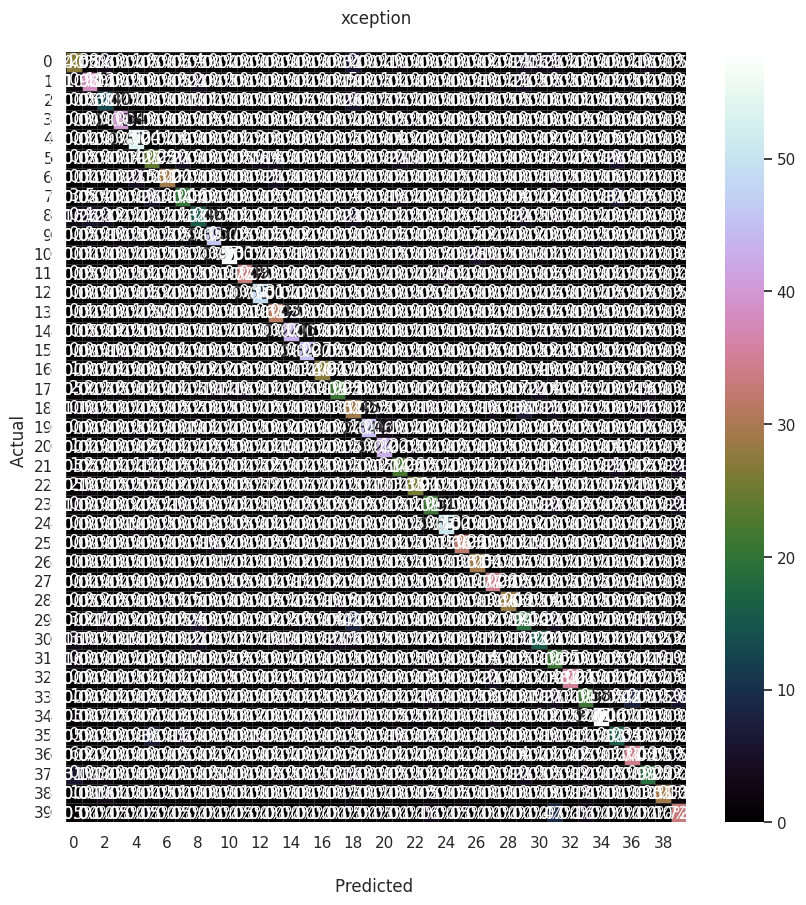

In [44]:
#group_names = ['True Neg','False Pos','False Neg','True Pos','True Pos','True Pos','True Pos','True Pos','True Pos']
fig,ax=plt.subplots(1,1,figsize=(10,10))
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}\n" for v1, v2 in
          zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(40,40)

ax = sns.heatmap(cm, annot=labels, fmt='', cmap='cubehelix',alpha=1,linewidths=0.5,linecolor=colors_dark[1])

ax.set_title('xception\n');
ax.set_xlabel('\nPredicted ')
ax.set_ylabel('Actual ');

# ## Ticket labels - List must be in alphabetical order
# ax.xaxis.set_ticklabels(['applauding','blowing_bubbles','brushing_teeth','cleaning _the_floor','climbing','cooking','cutting_trees','cutting_vegetables','drinking','feeding_horse','fishing','fixing_a_bike','fixing_a_car','gardening','holding_an_umbrella','jumping','looking_through_a_microscope','looking_through_a_telescope','phoning','playing_guitar','playing_violin','pouring_liquid','pushing_a_cart','reading','riding_a_bike','riding_a_horse','rowing_a_boat','running','shooting_an_arrow','smoking','taking_photos','texting_message','throwing_frisby','using_a_computer','walking_the_dog','washing_dishes','watching_TV','waving_hands','writing_on_a_board','writing_on_a_book'])
# ax.yaxis.set_ticklabels(['applauding','blowing_bubbles','brushing_teeth','cleaning _the_floor','climbing','cooking','cutting_trees','cutting_vegetables','drinking','feeding_horse','fishing','fixing_a_bike','fixing_a_car','gardening','holding_an_umbrella','jumping','looking_through_a_microscope','looking_through_a_telescope','phoning','playing_guitar','playing_violin','pouring_liquid','pushing_a_cart','reading','riding_a_bike','riding_a_horse','rowing_a_boat','running','shooting_an_arrow','smoking','taking_photos','texting_message','throwing_frisby','using_a_computer','walking_the_dog','washing_dishes','watching_TV','waving_hands','writing_on_a_board','writing_on_a_book'])

# ## Display the visualization of the Confusion Matrix.
# # plt.savefig("/content/gdrive/MyDrive/ALLOUTPUT/ae2.eps",transparent=True,dpi=1200)
# plt.show()

In [45]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# Step 1: One-hot encode y_test
y_test_binarized = label_binarize(y_test, classes=np.arange(40))  # 40 classes

# Step 2: model.predict() se probability lo
pred = model.predict(X_test)   # shape: (samples, 40)

# Step 3: ROC AUC calculate karo
score = roc_auc_score(y_test_binarized, pred, multi_class='ovo', average='weighted')
print("ROC AUC Score:", score)

61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step
ROC AUC Score: 0.9658977498110225


In [46]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# Step 1: Binarize y_test (BEFORE scoring)
y_test_bin = label_binarize(y_test, classes=list(range(40)))  # 40 classes
n_classes = y_test_bin.shape[1]

# Step 2: Get prediction probabilities from model
pred = model.predict(X_test)  # shape = (samples, 40), each row is probability per class

# Step 3: Compute all 4 ROC AUC Scores
macro_roc_auc_ovo = roc_auc_score(y_test_bin, pred, multi_class="ovo", average="macro")
weighted_roc_auc_ovo = roc_auc_score(y_test_bin, pred, multi_class="ovo", average="weighted")
macro_roc_auc_ovr = roc_auc_score(y_test_bin, pred, multi_class="ovr", average="macro")
weighted_roc_auc_ovr = roc_auc_score(y_test_bin, pred, multi_class="ovr", average="weighted")

# Step 4: Print the results
print(
    "One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} (weighted by prevalence)"
    .format(macro_roc_auc_ovo, weighted_roc_auc_ovo)
)
print(
    "One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} (weighted by prevalence)"
    .format(macro_roc_auc_ovr, weighted_roc_auc_ovr)
)


61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step
One-vs-One ROC AUC scores:
0.965388 (macro),
0.965898 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.965388 (macro),
0.965898 (weighted by prevalence)


In [47]:
y_test= label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39])
n_classes = y_test.shape[1]

y_test.shape

(1922, 40)

In [48]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(40):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


In [49]:
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(40)]))

In [50]:
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(7):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])


In [51]:
# Finally average it and compute AUC
mean_tpr /= 40

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])


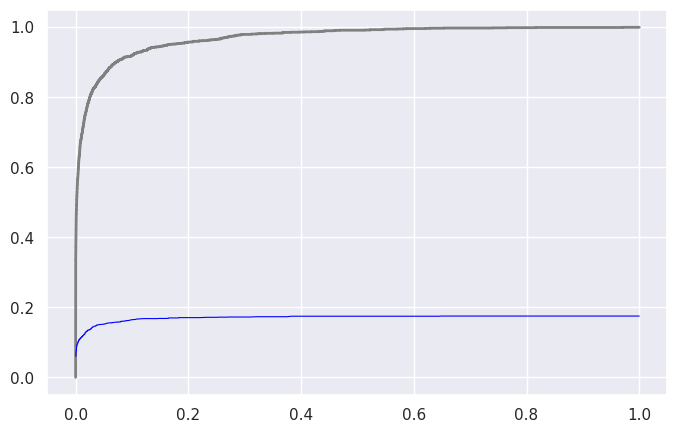

In [52]:
# Plot all ROC curves

plt.figure(figsize=(8,5))

plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="gray",

    linewidth=2

)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC (area = {0:0.2f})".format(roc_auc["macro"]),
    color="blue",

    linewidth=0.8

)

In [53]:
from itertools import cycle

color_cycle = cycle(["blue", "black", "gray", "green", "navy", "turquoise", "darkorange", "cornflowerblue", "teal",
                    "purple", "red", "darkgreen", "silver", "lime", "indigo", "gold", "slategray", "olive",
                    "darkcyan", "maroon", "cyan", "darkviolet", "peru", "orchid", "steelblue", "chocolate",
                    "mediumseagreen", "plum", "dodgerblue", "sienna", "mediumorchid", "cadetblue", "orangered",
                    "mediumblue", "darkslategray", "mediumturquoise", "darkred", "rosybrown", "mediumvioletred",
                    "deepskyblue", "saddlebrown"])

colors = [next(color_cycle) for _ in range(40)]

print(colors)


['blue', 'black', 'gray', 'green', 'navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'purple', 'red', 'darkgreen', 'silver', 'lime', 'indigo', 'gold', 'slategray', 'olive', 'darkcyan', 'maroon', 'cyan', 'darkviolet', 'peru', 'orchid', 'steelblue', 'chocolate', 'mediumseagreen', 'plum', 'dodgerblue', 'sienna', 'mediumorchid', 'cadetblue', 'orangered', 'mediumblue', 'darkslategray', 'mediumturquoise', 'darkred', 'rosybrown', 'mediumvioletred', 'deepskyblue']


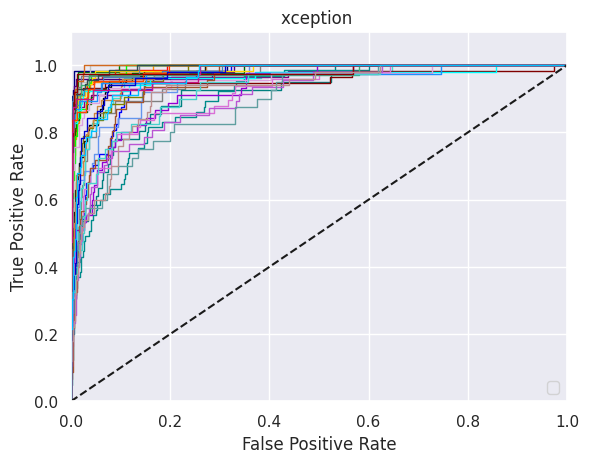

In [54]:
for i, color in zip(range(42), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        linewidth=1

        # label="ROC of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )
plt.plot(figsize=(20, 20))
plt.plot([0, 1], [0, 1.0], "k--")

plt.xlim([0.0 , 1.0])
plt.ylim([0.0 , 1.1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("xception ")
plt.legend(loc="lower right")
plt.grid('dark')
# sns.set_style('darkgrid')
#plt.style.use("dark_background")
plt.savefig("/content/drive/MyDrive/ALLOUTPUT/xceptionmultiroc_for_har.eps",dpi=1200)
plt.show()

61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step


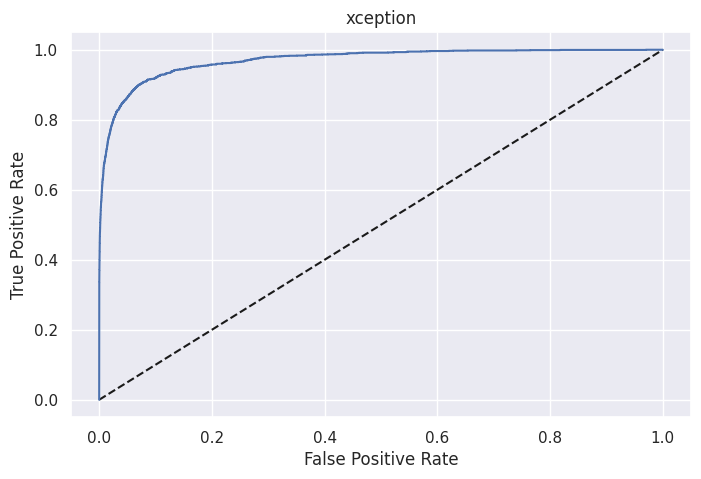

In [55]:

from sklearn.metrics import roc_curve, roc_auc_score
roc_auc = dict()
fig,ax=plt.subplots(1,1,figsize=(8,5))
from sklearn.metrics import roc_curve
pred = model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test.ravel(), pred.ravel())
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='xception')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('xception')
plt.savefig("/content/drive/MyDrive/ALLOUTPUT/xception_for_harroc.eps",dpi=600)
plt.show()

In [56]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import PrecisionRecallDisplay

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(40):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], pred[:, i])
    average_precision[i] = average_precision_score(y_test[:, i], pred[:, i])


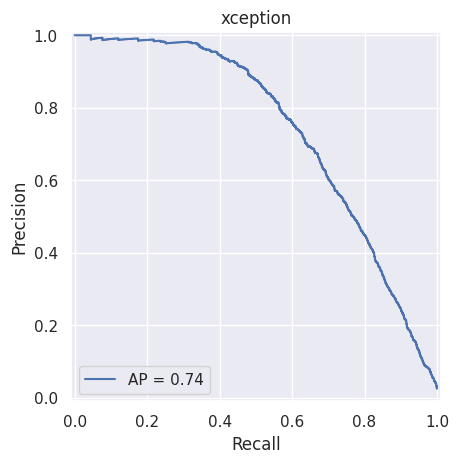

In [57]:
# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(
    y_test.ravel(), pred.ravel()
)
average_precision["micro"] = average_precision_score(y_test, pred, average="micro")

display = PrecisionRecallDisplay(
    recall=recall["micro"],
    precision=precision["micro"],
    average_precision=average_precision["micro"],
)
display.plot()
_ = display.ax_.set_title("xception")
plt.savefig("/content/drive/MyDrive/ALLOUTPUT/pr_har.eps",dpi=600)

In [58]:
import matplotlib.pyplot as plt
from itertools import cycle


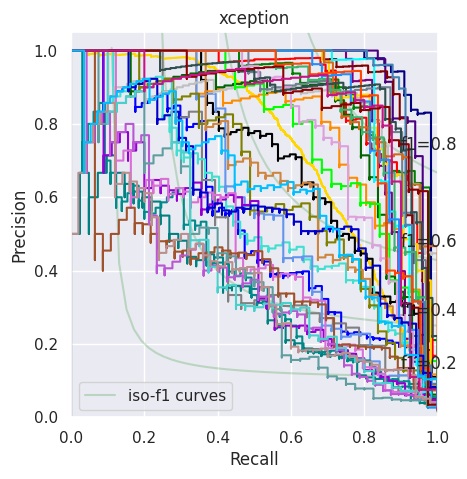

In [59]:
color_cycle = cycle(["blue", "black", "gray", "green", "navy", "turquoise", "darkorange", "cornflowerblue", "teal",
                    "purple", "red", "darkgreen", "silver", "lime", "indigo", "gold", "slategray", "olive",
                    "darkcyan", "maroon", "cyan", "darkviolet", "peru", "orchid", "steelblue", "chocolate",
                    "mediumseagreen", "plum", "dodgerblue", "sienna", "mediumorchid", "cadetblue", "orangered",
                    "mediumblue", "darkslategray", "mediumturquoise", "darkred", "rosybrown", "mediumvioletred",
                    "deepskyblue", "saddlebrown"])


_, ax = plt.subplots(figsize=(8, 5))
f_scores = np.linspace(0.2, 0.8, num=4)
lines, labels = [], []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    (l,) = plt.plot(x[y >= 0], y[y >= 0], color="green", alpha=0.2)
    plt.annotate("f1={0:0.1f}".format(f_score), xy=(0.9, y[45] + 0.02))

display = PrecisionRecallDisplay(
    recall=recall["micro"],
    precision=precision["micro"],
    # average_precision=average_precision["micro"],
)
display.plot(ax=ax, color="gold")

for i, color in zip(range(40), colors):
    display = PrecisionRecallDisplay(
        recall=recall[i],
        precision=precision[i]
        # average_precision=average_precision[i],
    )
    display.plot(ax=ax, color=color)

# add the legend for the iso-f1 curves
handles, labels = display.ax_.get_legend_handles_labels()
handles.extend([l])
labels.extend(["iso-f1 curves"])
# set the legend and the axes
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.legend(handles=handles, labels=labels, loc="best")
ax.set_title("xception")
plt.savefig("/content/drive/MyDrive/ALLOUTPUT/multipr_for_har.eps",dpi=600)
plt.show()

In [60]:
from sklearn.metrics import log_loss
log_loss(y_test, pred)


1.4383716792294232

In [61]:
pred=np.argmax(pred, axis=1)
y_test=np.argmax(y_test, axis=1)

In [62]:
from sklearn.metrics import cohen_kappa_score
cohen_kappa_score(y_test, pred,labels=None, weights=None, sample_weight=None)

np.float64(0.6538802080293735)

In [63]:
from sklearn.metrics import matthews_corrcoef
matthews_corrcoef(y_test, pred, )

np.float64(0.6541172694480234)

In [64]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model

In [65]:

# Load the .h5 model
model_h5 = load_model('/content/drive/MyDrive/Human.h5')

In [66]:
# Load the .tflite model
interpreter = tf.lite.Interpreter(model_path="/content/drive/MyDrive/Human.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()


In [67]:
# Define image size and labels
image_size = 150
activity_labels = ['applauding', 'blowing_bubbles', 'brushing_teeth', 'cleaning_the_floor', 'climbing', 'cooking', 'cutting_trees', 'cutting_vegetables', 'drinking', 'feeding_horse', 'fishing', 'fixing_a_bike', 'fixing_a_car', 'gardening', 'holding_an_umbrella', 'jumping', 'looking_through_a_microscope', 'looking_through_a_telescope', 'phoning', 'playing_guitar', 'playing_violin', 'pouring_liquid', 'pushing_a_cart', 'reading', 'riding_a_bike', 'riding_a_horse', 'rowing_a_boat', 'running', 'shooting_an_arrow', 'smoking', 'taking_photos', 'texting_message', 'throwing_frisby', 'using_a_computer', 'walking_the_dog', 'washing_dishes', 'watching_TV', 'waving_hands', 'writing_on_a_board', 'writing_on_a_book']



In [68]:
# Preprocess frame for the models
def preprocess_frame(frame):
    frame = cv2.resize(frame, (image_size, image_size))
    frame = frame / 255.0  # Normalize to [0, 1]
    return np.expand_dims(frame, axis=0)


In [69]:
# Webcam capture
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Preprocess frame
    preprocessed_frame = preprocess_frame(frame)

    # Predict using the .h5 model
    predictions_h5 = model_h5.predict(preprocessed_frame)
    predicted_label_h5 = activity_labels[np.argmax(predictions_h5)]

    # Predict using the .tflite model
    interpreter.set_tensor(input_details[0]['index'], preprocessed_frame)
    interpreter.invoke()
    predictions_tflite = interpreter.get_tensor(output_details[0]['index'])
    predicted_label_tflite = activity_labels[np.argmax(predictions_tflite)]

    # Display results
    cv2.putText(frame, f'Activity H5: {predicted_label_h5}', (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
    cv2.putText(frame, f'Activity TFLite: {predicted_label_tflite}', (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
    cv2.imshow('Webcam', frame)

    # Break the loop if 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [71]:
model.save("your_model.h5")
